<a href="https://colab.research.google.com/github/cormac-black/chekhovs-biscuit/blob/main/back_at_it.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mping
import numpy as np
import cv2


what is this? Is this just text?

Image 1



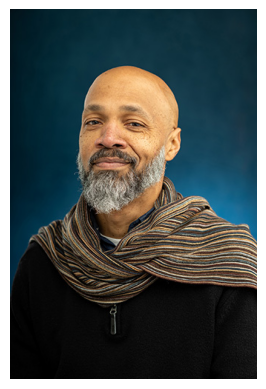

Image 2



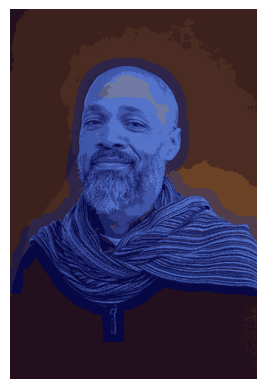

In [42]:
# image = mping.imread('/content/ai_hubris.jpg')
image = mping.imread('/content/headshot.jpg')
plt.imshow(image)
plt.axis('off')
print('Image 1\n')
plt.show()

# img_path = '/content/ai_hubris.jpg' # cv2 starts with image path
img_path = '/content/headshot.jpg' # cv2 starts with image path


## posterize it
img_raw = cv2.imread(img_path)

img_RGB = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

img_GRAY = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY)
edges = cv2.adaptiveThreshold(img_GRAY, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,9,5)
pixel_values = img_RGB_copy.reshape((-1, 3))
pixel_values = np.float32(pixel_values)
k = 8
_, labels, centers = cv2.kmeans(pixel_values, k, None, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, .2), 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)

quantized_img = centers[labels.flatten()]
quantized_img = quantized_img.reshape(img_RGB.shape)


## find_edges

edges1 = cv2.Canny(img_GRAY, 100, 165)
kernel = np.ones((5,5), np.uint8)
dilated_edges = cv2.dilate(edges1, kernel, iterations=5)

result = quantized_img.copy()
result[dilated_edges !=0] = [0,0,0]




img_GRAY_blur = cv2.medianBlur(img_GRAY, 3) # Changed ksize from 1 to 3 based on original comment's implied intent



img_filtered = cv2.applyColorMap(dilated_edges, cv2.COLORMAP_TURBO)






alpha = 0.6
beta = 0.5
gamma = 0.5

blended_img = cv2.addWeighted(cv2.cvtColor(quantized_img, cv2.COLOR_BGR2RGB), alpha, img_filtered, beta, gamma)

plt.imshow(blended_img)
plt.axis('off')
print('Image 2\n')
plt.show()